<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/Implementasi_Graph_Attention_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torch-geometric networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device yang digunakan:", device)

Device yang digunakan: cpu


In [8]:
dataset = KarateClub()

data = dataset[0].to(device)

In [5]:
print("\n--- Info Dataset ---")
print("Jumlah graph:", len(dataset))
print("Data Graph:", data)
print("Jumlah Node:", data.num_nodes)
print("Jumlah Edge:", data.num_edges)
print("Jumlah Fitur per Node:", data.num_node_features)
print("Jumlah Kelas (label):", dataset.num_classes)


--- Info Dataset ---
Jumlah graph: 1
Data Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Jumlah Node: 34
Jumlah Edge: 156
Jumlah Fitur per Node: 34
Jumlah Kelas (label): 4


In [9]:
labels = data.y.cpu().numpy()
unique_labels, counts = np.unique(labels, return_counts=True)

print("\n--- Distribusi Label ---")
for lbl, cnt in zip(unique_labels, counts):
    print(f"Label: {lbl}, Jumlah: {cnt}")


--- Distribusi Label ---
Label: 0, Jumlah: 13
Label: 1, Jumlah: 12
Label: 2, Jumlah: 4
Label: 3, Jumlah: 5


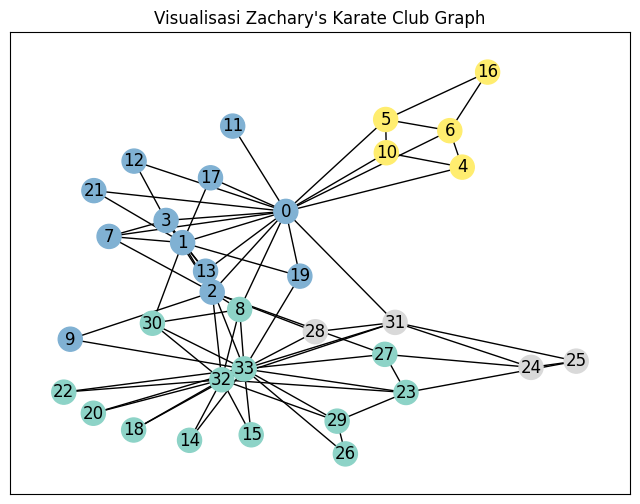

In [10]:
edge_index = data.edge_index.cpu().numpy()
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
edge_list = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edge_list)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # seed untuk reproduktifitas layout
nx.draw_networkx(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.Set3)
plt.title("Visualisasi Zachary's Karate Club Graph")
plt.show()

In [17]:
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:24] = True
test_mask[24:] = True

data.train_mask = train_mask.to(device)
data.test_mask = test_mask.to(device)

print(f"\nTrain mask: {data.train_mask.sum().item()} node(s)")
print(f"Test mask: {data.test_mask.sum().item()} node(s)")


Train mask: 24 node(s)
Test mask: 10 node(s)


In [18]:
class GATNet(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, heads=1):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels=num_features,
                             out_channels=hidden_dim,
                             heads=heads,
                             dropout=0.6)

        self.conv2 = GATConv(in_channels=hidden_dim * heads,
                             out_channels=num_classes,
                             heads=1,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [19]:
model = GATNet(num_features=data.num_node_features,
               hidden_dim=8,   # hidden dim
               num_classes=dataset.num_classes,
               heads=8).to(device)

print("\n--- Arsitektur Model GAT ---")
print(model)


--- Arsitektur Model GAT ---
GATNet(
  (conv1): GATConv(34, 8, heads=8)
  (conv2): GATConv(64, 4, heads=1)
)


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

In [21]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # Gunakan training mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)

    # Prediksi label
    pred = out.argmax(dim=1)

    # Evaluasi akurasi di data test
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

In [22]:
epochs = 200
for epoch in range(1, epochs+1):
    loss = train()
    acc = test()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

Epoch: 020, Loss: 0.9032, Test Accuracy: 0.4000
Epoch: 040, Loss: 0.6340, Test Accuracy: 0.6000
Epoch: 060, Loss: 0.5023, Test Accuracy: 0.6000
Epoch: 080, Loss: 0.5180, Test Accuracy: 0.6000
Epoch: 100, Loss: 0.3569, Test Accuracy: 0.6000
Epoch: 120, Loss: 0.2095, Test Accuracy: 0.6000
Epoch: 140, Loss: 0.3711, Test Accuracy: 0.6000
Epoch: 160, Loss: 0.2352, Test Accuracy: 0.6000
Epoch: 180, Loss: 0.2047, Test Accuracy: 0.6000
Epoch: 200, Loss: 0.3134, Test Accuracy: 0.6000
